In [148]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import copy
import shap

from scipy import linalg
from scipy.special import expit
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, 
                             RocCurveDisplay, PrecisionRecallDisplay)
from pandas.api.types import CategoricalDtype

## Step 1: Load incomplete dataset

In [15]:
### PLACEHOLDER TO LOAD THE TEST DATASET
###

incompdf = pd.read_csv("../../data/toy-dataset/biopsy_test_data.csv", index_col=0)
incompdf.head()

,V1,V2,V3,V4,V5,V7,V8,V9,class
1,5.0,1.0,1,1,2,3,1,1,benign
2,5.0,4.0,4,5,7,3,2,1,benign
3,3.0,1.0,1,1,2,3,1,1,benign
4,NaN,8.0,8,1,3,3,7,1,benign
5,4.0,1.0,1,3,2,3,1,1,benign


In [16]:
# Additional command to convert the class variable into categorical format
class_type = CategoricalDtype(categories=["benign", "malignant"])
incompdf["class"] = incompdf["class"].astype(class_type)

In [17]:
incompdf["class"].head()

1    benign
2    benign
3    benign
4    benign
5    benign
Name: class, dtype: category
Categories (2, object): ['benign', 'malignant']

In [24]:
incompdf["class"].values.codes[:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int8)

In [40]:
# Create one-hot encoded version
incompdf1 = pd.get_dummies(incompdf, drop_first=True)
incompdf1.head()

,V1,V2,V3,V4,V5,V7,V8,V9,class_malignant
1,5.0,1.0,1,1,2,3,1,1,0
2,5.0,4.0,4,5,7,3,2,1,0
3,3.0,1.0,1,1,2,3,1,1,0
4,NaN,8.0,8,1,3,3,7,1,0
5,4.0,1.0,1,3,2,3,1,1,0


In [41]:
incompdf1["class_malignant"].value_counts()

0    458
1    241
Name: class_malignant, dtype: int64

In [156]:
# Create a version with V1 binarized
incompdf2 = incompdf1.copy()
incompdf2["V1"] = incompdf2["V1"].apply(
    lambda x: np.NaN if np.isnan(x) else 1 if x > 4 else 0
)
incompdf2["V1"].value_counts()

0.0    342
1.0    242
Name: V1, dtype: int64

In [157]:
incompdf2["V1"].isna().sum()

115

In [ ]:
### PLACEHOLDER TO LOAD THE ACTUAL DATASET
###

## Step 2: Implement multiple imputation with PMM

In [25]:
def ImputeRandomSample(data, seed=None):
    """
    Impute missing values using one of the observed values for a given variable 
    (univariate imputation).
    This function iterates over all columns in a data frame and imputes as necessary.
    
    Parameters
    ----------
    data : Pandas DataFrame
        Data frame to be imputed
    seed : None, optional
        Random seed for reproducibility
    
    Returns
    -------
    Pandas DataFrame
        Imputed data frame
    """
    # Copy data frame
    imp = data.copy()
    
    # Set random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    # Iterate over all variables in the data frame
    for c in data.columns:
        # Find rows to be imputed and number of missing observations
        mr = data[c].isna()
        n = mr.sum()
        
        # Collect observed data for sampling
        obs = data[c].dropna().values
        
        # Impute using random samples
        # We assume that the data is not fully missing but only partially
        imp.loc[mr, c] = np.random.choice(obs, size=n, replace=True)
        
    return imp

In [26]:
# The following function performs single (not multiple yet) imputation using PMM
# which will act as the building block for the MICE implementation later on

def ImputePMM(data, missingflag, d=5, k=1e-5, seed=None, targets=None):
    """
    Perform imputation using the predictive mean matching (PMM) method. 
    If the target variables are not specified, it assumes that all variables 
    are continuous and can be modelled using the Bayesian linear model.
    
    Parameters
    ----------
    data : Pandas DataFrame
        Data frame to be imputed
    missingflag : Pandas DataFrame
        A boolean data frame with the exact same dimension as `data`, with an
        indicator that shows if a given observation and variable is missing in
        `data`
    d : int, optional
        Number of donors in the donor set (default = 5)
    k : float, optional
        Ridge parameter for numerical stability (default = 1e-5)
    seed : int, optional
        Random seed
    targets : list, optional
        List of target variables to be imputed (assumed to be continuous)
    
    Returns
    -------
    Pandas DataFrame
        Imputed data frame
    """
    # Set random seed
    if seed is not None:
        np.random.seed(seed)
    
    # Iterate over all columns
    if targets is None:
        targets = data.columns
    for i, c in enumerate(targets):
        # Separate out variable to be imputed and predictors - with their respective
        # flags
        y = data[c]
        yflag = missingflag[c]
        X = data.drop(c, axis=1)
        Xflag = missingflag.drop(c, axis=1)
        
        # Skip if no missing value
        if yflag.sum() == 0:
            continue
        
        # Separate out observed and missing
        Xobs = X[~yflag].values
        Xmis = X[yflag].values
        yobs = y[~yflag].values
        ymis = y[yflag].values
        
        # Calculate regression weights (Algorithm 3.1)
        S = np.transpose(Xobs) @ Xobs
        V = np.linalg.inv(S + k * np.diag(np.diag(S)))
        bhat = V @ np.transpose(Xobs) @ yobs
        
        # Calculate noise variance
        df = len(yobs) - Xobs.shape[1]
        gdot = np.random.chisquare(df)
        res = yobs - Xobs @ bhat
        sigdot = np.sqrt(np.transpose(res) @ res / gdot)
        
        # Draw beta from the posterior distribution
        z1 = np.random.normal(size=Xobs.shape[1])
        bdot = bhat + sigdot * z1 @ np.linalg.cholesky(V)
        
        # Calculate the imputed values and overwrite data matrix
        # NOTE: This is the Bayesian linear model approach, not PMM
        #z2 = np.random.normal(size=len(ymis))
        #yimp = Xmis @ bdot + z2 * sigdot
        #data.loc[yflag, c] = yimp
        
        # Calculate distances
        eta = np.subtract.outer(np.dot(Xobs, bhat).ravel(), np.dot(Xmis, bdot).ravel())
        eta = np.abs(eta)
        
        # Identify donor sets for each missing value
        ind = np.argsort(eta, axis=0)
        donorind = ind[:d, :]
        
        # Draw random donor for each missing value
        selectedind = np.random.randint(0, d, size=len(ymis))
        selecteddonorind = np.diag(donorind[np.ix_(selectedind, np.arange(len(ymis)))])
        yimp = yobs[selecteddonorind]
        
        # Overwrite data matrix
        data.loc[yflag, c] = yimp

    return data

In [27]:
# Helper function to calculate statistics of imputed data
def getImputedStats(data, missingflag):
    # Initialize arrays for mean and SD
    mu = np.zeros(data.shape[1])
    sigma = np.zeros(data.shape[1])
    
    for i, c in enumerate(data.columns):
        # Extract missing data
        miss = data.loc[missingflag[c], c]
        
        # Get statistics
        mu[i] = miss.mean()
        sigma[i] = miss.std(ddof=1)
    
    return mu, sigma

# Main function for MICE using PMM
def MICEPMM(data, m=10, maxit=5, d=5, k=1e-5, seed=123):
    """
    Implement multivariate imputation by chained equations (MICE) using 
    predictive mean matching (PMM) method. This function assumes that all
    variables are continuous and can be modelled using a Bayesian linear model.
    Furthermore, it assumes a fully conditional specification (FCS), which makes
    the original MICE framework.
    
    Parameters
    ----------
    data : Pandas DataFrame
        Data frame to be imputed
    m : int, optional
        Number of multiply imputed data to be generated (default = 10)
    maxit : int, optional
        Maximum number of iterations for the MICE algorithm (default = 5)
    d : int, optional
        Number of donors in the donor set (default = 5)
    k : float, optional
        Ridge parameter for numerical stability (default = 1e-5)
    seed : int, optional
        Random seed
    
    Returns
    -------
    dict
        Python dictionary with the imputed data (`imp`), missing data flag (`missingflag`),
        and the chain statistics (`chainmean` and `chainstd`)
    """
    # Set random seed
    if seed is not None:
        np.random.seed(seed)

    # Create flags for missing value
    missingflag = data.isna()
    
    # Make m copies of the data
    imp = []
    for _ in range(m):
        # Initialize using random sample
        imp.append(ImputeRandomSample(data))
    
    # Initialize chain statistics
    chainmean = np.empty((data.shape[1], m, maxit+1))
    chainstd = np.empty((data.shape[1], m, maxit+1))
    for i in range(m):
        chainmean[:, i, 0], chainstd[:, i, 0] = getImputedStats(imp[i], missingflag)
    
    # Iterate over maxit
    for j in tqdm(range(maxit)):
        #print("Iteration {}".format(j))
        
        for i in range(m):
            # Impute using PMM
            imp[i] = ImputePMM(imp[i], missingflag, d=d, k=k)
        
            # Calculate updated chain statistics
            chainmean[:, i, j+1], chainstd[:, i, j+1] = getImputedStats(imp[i], missingflag)
    
    # Return multiply imputed data and chain statistics
    res = {
        "imp": imp,
        "missingflag": missingflag,
        "chainmean": chainmean,
        "chainstd": chainstd
    }
    return res

In [28]:
# Helper function to present imputed value across different imputations
def getImputedData(res, colname):
    """
    Helper function to get a data frame of imputed values for a given variable
    
    Parameters
    ----------
    res : dict
        Python dictionary returned by `MICEPMM`
    colname : str
        Variable for which the imputed data is to be shown
    
    Returns
    -------
    Pandas DataFrame
        Data frame showing observations with missing data only. Each column represents
        the output from each imputation model
    """
    # Retrieve relevant data
    implist, missingflag = res["imp"], res["missingflag"]
    
    # Extract relevant missing flag
    yflag = missingflag[colname]
    
    # Iterate over all imputed data
    impcombined = []
    for i, data in enumerate(implist):
        # Extract imputed values
        data = data.loc[yflag]
        data = data.rename(columns={colname: colname + str(i)})
        impcombined.append(data[colname + str(i)])
    
    impcombined = pd.concat(impcombined, axis=1)
    
    return impcombined

In [50]:
# Helper function to visualise the chain statistics
def ChainStatsViz(res, maxvar=3):
    """
    Constructs a trace plot of chain statistics based on the `MICEPMM` output
    
    Parameters
    ----------
    res : dict
        Python dictionary returned by `MICEPMM`
    maxvar : int, optional
        Maximum number of variables to be visualized (default = 3). Note that only
        variables with missing data will be shown
    
    Returns
    -------
    matplotlib.pyplot.figure
        Figure showing the trace plots
    """
    # Retrieve chain mean and standard deviation
    chainmean, chainstd = res["chainmean"], res["chainstd"]
    
    # Pick first maxvar variables with missing data
    allvars = pd.Series(res["missingflag"].columns.values)
    missingvars = res["missingflag"].columns[res["missingflag"].sum() > 0]
    if len(missingvars) < maxvar:
        maxvar = len(missingvars)
    else:
        missingvars = missingvars[:maxvar]
    missingvarsind = allvars[allvars.isin(missingvars)].index
    
    # Get number of imputed data
    m = len(res["imp"])
    
    # Placeholder for plotting
    fig, axs = plt.subplots(figsize=(8, maxvar*3), ncols=2, nrows=maxvar, 
                            sharex=True)
    cmap = cm.get_cmap("jet", 10) # If m > 10, it will rotate back to start
    
    # Generate plot for each variable and imputation
    for i, idx in enumerate(missingvarsind):
        # Plot chain mean
        for j in range(m):
            axs[i, 0].plot(chainmean[i, j, :], color=cmap(j % 10), alpha=0.7)
        axs[i, 0].set_title("{}: mean".format(allvars[idx]))
        
        # Plot chain SD
        for j in range(m):
            axs[i, 1].plot(chainstd[i, j, :], color=cmap(j % 10), alpha=0.7)
        axs[i, 1].set_title("{}: SD".format(allvars[idx]))
    
    return fig

In [30]:
"""
(Note from 3.4.4 of Van Buuren)
"Morris et al. (2014) advise to spend efforts on specifying the imputation model correctly, 
rather than expecting predictive mean matching to do the work."

(Note from 3.6.2 of Van Buuren)
The logreg, polr and polyreg methods in mice implement option 5.

(Note from 3.6.3 of Van Buuren)
Imputation of categorical data is more difficult than continuous data. As a rule of thumb, 
in logistic regression we need at least 10 events per predictor in order to get reasonably 
stable estimates of the regression coefficients (Van Belle, 2002, p. 87).

Next step:
1. Implement logreg and polyreg (either bootstrap or using data augmentation)
2. Implement tree-based model with XAI
3. Consider option to extend PMM using GLM as underlying model
"""

'\n(Note from 3.4.4 of Van Buuren)\n"Morris et al. (2014) advise to spend efforts on specifying the imputation model correctly, \nrather than expecting predictive mean matching to do the work."\n\n(Note from 3.6.2 of Van Buuren)\nThe logreg, polr and polyreg methods in mice implement option 5.\n\n(Note from 3.6.3 of Van Buuren)\nImputation of categorical data is more difficult than continuous data. As a rule of thumb, \nin logistic regression we need at least 10 events per predictor in order to get reasonably \nstable estimates of the regression coefficients (Van Belle, 2002, p. 87).\n\nNext step:\n1. Implement logreg and polyreg (either bootstrap or using data augmentation)\n2. Implement tree-based model with XAI\n3. Consider option to extend PMM using GLM as underlying model\n'

In [168]:
# Main function for imputation using logistic regression with bootstrap

def ImputeLogRegBoot(data, missingflag, d=5, k=1e-5, seed=None, targets=None):
    """
    Perform imputation using the logistic regression method with bootstrapping. 
    Note that target columns should be specified if not all variables are binary.
    Note that this implementation also assumes that the binary variables have
    been encoded as 0s and 1s.
    
    Parameters
    ----------
    data : Pandas DataFrame
        Data frame to be imputed
    missingflag : Pandas DataFrame
        A boolean data frame with the exact same dimension as `data`, with an
        indicator that shows if a given observation and variable is missing in
        `data`
    d : int, optional
        Number of donors in the donor set (default = 5)
    k : float, optional
        Ridge parameter for numerical stability (default = 1e-5)
    seed : int, optional
        Random seed
    targets : list, optional
        Target columns to be imputed
    
    Returns
    -------
    Pandas DataFrame
        Imputed data frame
    """
    # Set random seed
    if seed is not None:
        np.random.seed(seed)
    
    # Iterate over all columns
    if targets is None:
        targets = data.columns
    for i, c in enumerate(targets):
        # Separate out variable to be imputed and predictors - with their respective
        # flags
        y = data[c]
        yflag = missingflag[c]
        X = data.drop(c, axis=1)
        Xflag = missingflag.drop(c, axis=1)
        
        # Skip if no missing value
        if yflag.sum() == 0:
            continue
        
        # Separate out observed and missing
        Xobs = X[~yflag].values
        Xmis = X[yflag].values
        yobs = y[~yflag].values
        ymis = y[yflag].values
        
        # Stop process if y is not binary
        if len(np.unique(yobs)) > 2:
            raise ValueError("Column {} has {} unique values".format(c, len(np.unique(yobs))))
        
        # Resample observed data using bootstrap
        resampled_idx = np.random.choice(np.arange(yobs.shape[0]), size=yobs.shape[0], 
                                         replace=True)
        Xobs1 = Xobs[resampled_idx, :]
        yobs1 = yobs[resampled_idx]
        
        # Train logistic regression model
        Xobs1 = sm.add_constant(Xobs1)
        lr_model = sm.Logit(yobs1, Xobs1).fit(disp=0) # suppress optim message
        
        # Predict probabilities using the fitted model
        pmis = lr_model.predict(sm.add_constant(Xmis))
        
        # Generate imputed binary values based on probabilities
        yimp = (np.random.uniform(size=ymis.shape[0]) < pmis).astype(float)
        
        # Overwrite data matrix
        data.loc[yflag, c] = yimp

    return data

In [167]:
# Main function for imputation using logistic regression with data augmentation

def ImputeLogRegAugment(data, missingflag, d=5, k=1e-5, seed=None, targets=None):
    """
    Perform imputation using the logistic regression method with data augmentation
    according to White, Daniel, and Royston (2010).
    Note that target columns should be specified if not all variables are binary.
    Note that this implementation also assumes that the binary variables have
    been encoded as 0s and 1s.
    A key difference against R implementation is the use of standard binomial
    instead of quasibinomial.
    
    Parameters
    ----------
    data : Pandas DataFrame
        Data frame to be imputed
    missingflag : Pandas DataFrame
        A boolean data frame with the exact same dimension as `data`, with an
        indicator that shows if a given observation and variable is missing in
        `data`
    d : int, optional
        Number of donors in the donor set (default = 5)
    k : float, optional
        Ridge parameter for numerical stability (default = 1e-5)
    seed : None, optional
        Random seed
    targets : None, optional
        Target columns to be imputed
    
    Returns
    -------
    Pandas DataFrame
        Imputed data frame
    """
    # Set random seed
    if seed is not None:
        np.random.seed(seed)
    
    # Iterate over all columns
    if targets is None:
        targets = data.columns
    for i, c in enumerate(targets):
        # Separate out variable to be imputed and predictors - with their respective
        # flags
        y = data[c]
        yflag = missingflag[c]
        X = data.drop(c, axis=1)
        Xflag = missingflag.drop(c, axis=1)
        
        # Skip if no missing value
        if yflag.sum() == 0:
            continue
        
        # Perform data augmentation
        Xaug, yaug, Xflagaug, yflagaug = _augment_data(X, y, Xflag, yflag)
        
        # Separate out observed and missing
        Xobs = Xaug[~yflagaug].values
        Xmis = Xaug[yflagaug].values
        yobs = yaug[~yflagaug].values
        ymis = yaug[yflagaug].values
        
        # Stop process if y is not binary
        if len(np.unique(yobs)) > 2:
            raise ValueError("Column {} has {} unique values".format(c, len(np.unique(yobs))))
        
        # Train logistic regression model
        Xobs = sm.add_constant(Xobs)
        lr_model = sm.Logit(yobs, Xobs).fit(disp=0) # suppress optim message
        
        # Sample betas from (estimated) posterior distribution
        cov_unscaled = lr_model.cov_params(scale=False)
        cov_sqrt = linalg.cholesky(cov_unscaled, lower=True)
        betas = lr_model.params.values
        beta_star = betas + np.dot(cov_sqrt, np.random.normal(len(betas)))
        
        # Predict probabilities using betas
        pmis = expit(np.dot(sm.add_constant(Xmis), beta_star))
        
        # Generate imputed binary values based on probabilities
        yimp = (np.random.uniform(size=ymis.shape[0]) < pmis).astype(float)
        
        # Overwrite data matrix
        data.loc[yflag, c] = yimp

    return data

def _augment_data(X, y, Xflag, yflag):
    # Helper function for data augmentation based on White, Daniel, Royston (2010)
    
    # Get number of categories and number of predictors
    p = X.shape[1]
    k = y.dropna().nunique()
    nr = 2 * p * k
    
    # Calculate column wise mean and SD, then construct a matrix
    mu = X.mean()
    sig = X.std(ddof=1) # R implements sample variance by default, but not Python
    mu_mtrx = np.tile(mu.values.reshape(1, -1), (nr, 1))
    sig_mtrx = np.tile(sig.values.reshape(1, -1), (nr, 1))
    
    # Create shift matrix and outcome label vector
    shift_mtrx = linalg.block_diag(*tuple([[[.5], [-.5]]] * p))
    shift_mtrx = np.tile(shift_mtrx, (k, 1))
    ynew = np.repeat(np.arange(k), 2 * p)
    
    # Create augmented data
    aug = mu_mtrx + shift_mtrx * sig_mtrx
    aug = pd.DataFrame(aug, columns=X.columns)
    ynew = pd.Series(ynew)
    augflag = pd.DataFrame(np.zeros(nr, ).astype(bool), columns=X.columns)
    
    # Augment to the original data
    Xaug = pd.concat([X, aug], ignore_index=True)
    yaug = pd.concat([y, ynew], ignore_index=True)
    Xflagaug = pd.concat([Xflag, augflag], ignore_index=True)
    yflagaug = pd.concat([yflag, pd.Series(np.zeros(nr).astype(bool))], ignore_index=True)
    
    return Xaug, yaug, Xflagaug, yflagaug

In [ ]:
# Main function for imputation using multinomial regression with data augmentation
# Do this later

In [162]:
# Main function to perform MICE using logistic regression

def MICELogReg(data, m=10, maxit=5, d=5, k=1e-5, seed=123, method="boot"):
    """
    Implement multivariate imputation by chained equations (MICE) using 
    logistic regression method. This function assumes that all
    variables are binary and are encoded as 0s and 1s. Two methods of logistic
    regression imputation are supported, one based on bootstrap approach and the
    other based on Bayesian approach (with data augmentation).
    Furthermore, it assumes a fully conditional specification (FCS), which makes
    the original MICE framework.
    
    Parameters
    ----------
    data : Pandas DataFrame
        Data frame to be imputed
    m : int, optional
        Number of multiply imputed data to be generated (default = 10)
    maxit : int, optional
        Maximum number of iterations for the MICE algorithm (default = 5)
    d : int, optional
        Number of donors in the donor set (default = 5)
    k : float, optional
        Ridge parameter for numerical stability (default = 1e-5)
    seed : int, optional
        Random seed
    method : str, optional
        Logistic regression method, "boot" for bootstrap approach (default) and
        "bayes" for Bayesian approach
    
    Returns
    -------
    dict
        Python dictionary with the imputed data (`imp`), missing data flag (`missingflag`),
        and the chain statistics (`chainmean` and `chainstd`)
    """
    # Set random seed
    if seed is not None:
        np.random.seed(seed)

    # Create flags for missing value
    missingflag = data.isna()
    
    # Make m copies of the data
    imp = []
    for _ in range(m):
        # Initialize using random sample
        imp.append(ImputeRandomSample(data))
    
    # Initialize chain statistics
    chainmean = np.empty((data.shape[1], m, maxit+1))
    chainstd = np.empty((data.shape[1], m, maxit+1))
    for i in range(m):
        chainmean[:, i, 0], chainstd[:, i, 0] = getImputedStats(imp[i], missingflag)
    
    # Iterate over maxit
    for j in tqdm(range(maxit)):
        #print("Iteration {}".format(j))
        
        for i in range(m):
            # Impute using appropriate method
            if method == "boot":
                imp[i] = ImputeLogRegBoot(imp[i], missingflag, d=d, k=k)
            elif method == "bayes":
                imp[i] = ImputeLogRegBayes(imp[i], missingflag, d=d, k=k)
            else:
                raise ValueError("Invalid method: {}".format(method))
        
            # Calculate updated chain statistics
            chainmean[:, i, j+1], chainstd[:, i, j+1] = getImputedStats(imp[i], missingflag)
    
    # Return multiply imputed data and chain statistics
    res = {
        "imp": imp,
        "missingflag": missingflag,
        "chainmean": chainmean,
        "chainstd": chainstd
    }
    return res

In [163]:
# Main function to perform MICE on multiple data types

def MICE(data, targets_cat, targets_num, m=10, maxit=5, d=5, k=1e-5, seed=123, 
         method_cat="boot", method_num="pmm"):
    """
    Implement multivariate imputation by chained equations (MICE). This function
    requires continuous and categorical target variables to be explicitly specified.
    Appropriate imputation method will then be applied to each target variable type.
    
    Parameters
    ----------
    data : Pandas DataFrame
        Data frame to be imputed
    targets_cat : list
        List of categorical target variables to be imputed. Pass an empty list if
        no categorical variable is to be imputed
    targets_num : list
        List of numeric target variables to be imputed. Pass an empty list if
        no numeric variable is to be imputed
    m : int, optional
        Number of multiply imputed data to be generated (default = 10)
    maxit : int, optional
        Maximum number of iterations for the MICE algorithm (default = 5)
    d : int, optional
        Number of donors in the donor set (default = 5)
    k : float, optional
        Ridge parameter for numerical stability (default = 1e-5)
    seed : int, optional
        Random seed
    method_cat : str, optional
        Imputation method for categorical target variables. Supports "boot" (default),
        "bayes", and "pmm"
    method_num : str, optional
        Imputation method for numeric target variables. Only supports "pmm" (default)
    
    Returns
    -------
    dict
        Python dictionary with the imputed data (`imp`), missing data flag (`missingflag`),
        and the chain statistics (`chainmean` and `chainstd`)
    """
    # Check validity of imputation methods
    assert method_cat in ["pmm", "boot", "bayes"], "Invalid method : {}".format(method_cat)
    assert method_num in ["pmm"], "Invalid method: {}".format(method_num)
    
    # Set random seed
    if seed is not None:
        np.random.seed(seed)

    # Create flags for missing value
    missingflag = data.isna()
    
    # Make m copies of the data
    imp = []
    for _ in range(m):
        # Initialize using random sample
        imp.append(ImputeRandomSample(data))
    
    # Initialize chain statistics
    chainmean = np.empty((data.shape[1], m, maxit+1))
    chainstd = np.empty((data.shape[1], m, maxit+1))
    for i in range(m):
        chainmean[:, i, 0], chainstd[:, i, 0] = getImputedStats(imp[i], missingflag)
    
    # Define dictionary to map appropriate functions
    imputefunc = {
        "pmm" : ImputePMM,
        "boot": ImputeLogRegBoot,
        "bayes": ImputeLogRegAugment,
    }
    
    # Iterate over maxit
    for j in tqdm(range(maxit)):
        #print("Iteration {}".format(j))
        
        for i in range(m):
            # Impute using appropriate method for each data type
            if len(targets_cat) > 0:
                imp[i] = imputefunc[method_cat](imp[i], missingflag, d=d, k=k, 
                                                targets=targets_cat)
            if len(targets_num) > 0:
                imp[i] = imputefunc[method_num](imp[i], missingflag, d=d, k=k, 
                                                targets=targets_num)
        
            # Calculate updated chain statistics
            chainmean[:, i, j+1], chainstd[:, i, j+1] = getImputedStats(imp[i], missingflag)
    
    # Return multiply imputed data and chain statistics
    res = {
        "imp": imp,
        "missingflag": missingflag,
        "chainmean": chainmean,
        "chainstd": chainstd
    }
    return res

## Step 2B: Apply multiple imputation on the dataset

In [45]:
# Apply multiple imputation
targets_cat = []
targets_num = ["V1", "V2"]
impres = MICE(incompdf1, targets_cat, targets_num)

100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


In [47]:
# Retrieve imputed data for V1
getImputedData(impres, "V1").head(10)

,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19
4,1.0,3.0,3.0,1.0,1.0,5.0,10.0,5.0,1.0,10.0
6,8.0,5.0,10.0,1.0,10.0,10.0,8.0,8.0,3.0,9.0
37,5.0,4.0,7.0,1.0,5.0,10.0,10.0,7.0,3.0,9.0
45,10.0,10.0,4.0,1.0,7.0,6.0,8.0,8.0,4.0,5.0
51,5.0,10.0,5.0,2.0,5.0,10.0,8.0,5.0,1.0,5.0
55,10.0,10.0,5.0,4.0,4.0,7.0,10.0,10.0,10.0,9.0
58,6.0,7.0,8.0,2.0,5.0,5.0,5.0,10.0,1.0,5.0
63,10.0,10.0,10.0,5.0,10.0,10.0,9.0,9.0,1.0,9.0
81,3.0,6.0,3.0,1.0,3.0,7.0,9.0,8.0,1.0,5.0
83,1.0,1.0,4.0,1.0,5.0,1.0,3.0,2.0,1.0,8.0


In [48]:
# Retrieve imputed data for V2
getImputedData(impres, "V2").head(10)

,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
37,6.0,3.0,10.0,4.0,7.0,10.0,5.0,2.0,10.0,10.0
81,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
85,4.0,3.0,10.0,8.0,8.0,8.0,7.0,2.0,10.0,5.0
87,3.0,2.0,5.0,3.0,6.0,7.0,7.0,1.0,7.0,5.0
96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
101,3.0,3.0,8.0,2.0,8.0,5.0,7.0,3.0,10.0,6.0
105,4.0,4.0,10.0,8.0,10.0,10.0,10.0,3.0,10.0,10.0
107,8.0,4.0,8.0,5.0,7.0,7.0,6.0,3.0,8.0,10.0
113,1.0,2.0,2.0,4.0,1.0,6.0,4.0,1.0,4.0,3.0
125,6.0,3.0,10.0,4.0,6.0,10.0,8.0,1.0,10.0,8.0


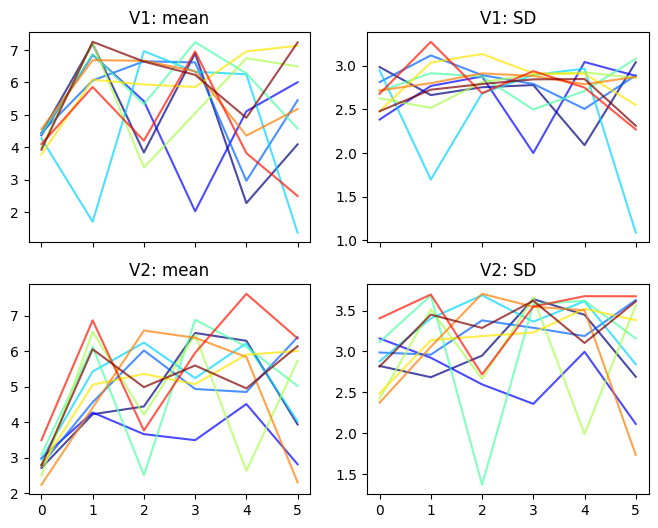

In [51]:
chainfig = ChainStatsViz(impres)

In [169]:
# Test code on dataset with binary target
# Apply multiple imputation
targets_cat = ["V1"]
targets_num = ["V2"]
impres = MICE(incompdf2, targets_cat, targets_num)

100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


In [170]:
# Retrieve imputed data for V1
getImputedData(impres, "V1").head(10)

,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19
4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
37,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
45,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
51,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
55,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
58,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
63,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [171]:
# Retrieve imputed data for V2
getImputedData(impres, "V2").head(10)

,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
37,10.0,10.0,6.0,10.0,10.0,3.0,10.0,10.0,10.0,3.0
81,1.0,3.0,1.0,1.0,1.0,1.0,4.0,1.0,2.0,1.0
85,10.0,3.0,5.0,10.0,5.0,4.0,7.0,8.0,10.0,2.0
87,7.0,4.0,2.0,9.0,3.0,4.0,5.0,5.0,10.0,6.0
96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
101,10.0,4.0,3.0,10.0,4.0,3.0,8.0,7.0,10.0,4.0
105,10.0,10.0,6.0,10.0,8.0,4.0,5.0,10.0,10.0,5.0
107,4.0,10.0,6.0,8.0,8.0,6.0,10.0,8.0,10.0,10.0
113,5.0,3.0,3.0,6.0,3.0,3.0,4.0,3.0,8.0,1.0
125,6.0,10.0,4.0,6.0,6.0,4.0,7.0,8.0,10.0,3.0


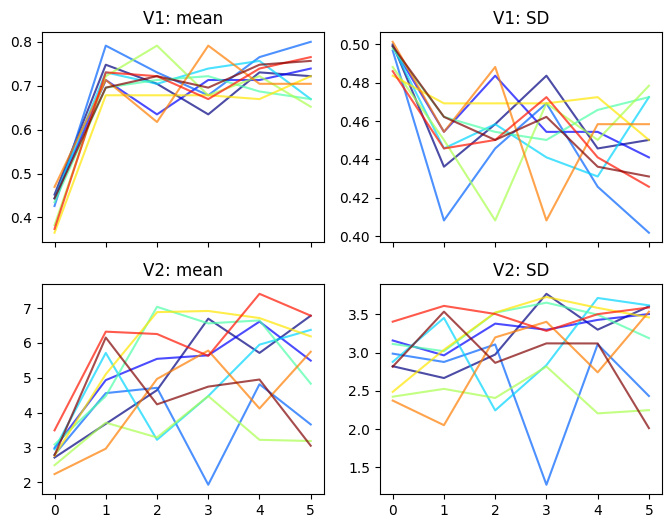

In [172]:
chainfig = ChainStatsViz(impres)

In [173]:
# Test using PMM for binary variable(s)
# Apply multiple imputation
targets_cat = ["V1"]
targets_num = ["V2"]
impres = MICE(incompdf2, targets_cat, targets_num, method_cat="pmm")

100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


In [174]:
# Retrieve imputed data for V1
getImputedData(impres, "V1").head(10)

,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
6,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
37,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
45,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
51,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
55,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
58,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
63,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
81,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [175]:
# Retrieve imputed data for V2
getImputedData(impres, "V2").head(10)

,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
37,6.0,8.0,10.0,6.0,8.0,10.0,10.0,4.0,10.0,10.0
81,1.0,1.0,1.0,1.0,3.0,1.0,2.0,1.0,2.0,3.0
85,10.0,3.0,10.0,6.0,7.0,10.0,10.0,1.0,10.0,8.0
87,8.0,4.0,5.0,2.0,4.0,6.0,5.0,3.0,7.0,5.0
96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
101,4.0,3.0,10.0,3.0,4.0,5.0,5.0,4.0,10.0,8.0
105,5.0,5.0,5.0,5.0,10.0,10.0,10.0,3.0,10.0,10.0
107,6.0,10.0,8.0,5.0,8.0,10.0,10.0,5.0,7.0,7.0
113,3.0,2.0,4.0,3.0,3.0,2.0,6.0,2.0,4.0,4.0
125,4.0,2.0,8.0,4.0,6.0,7.0,5.0,3.0,4.0,7.0


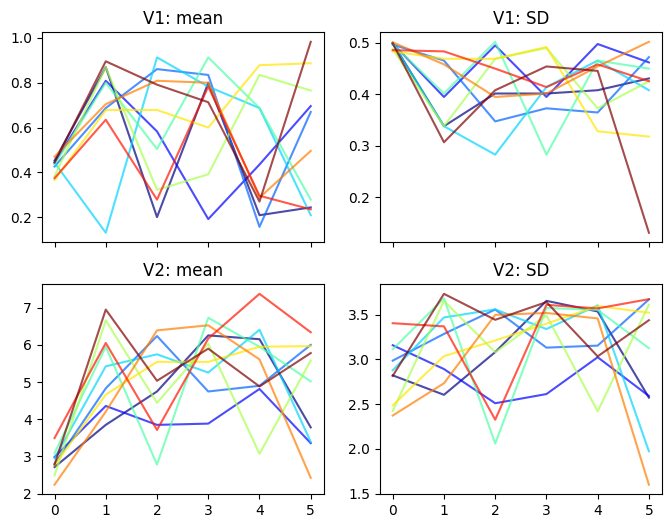

In [176]:
chainfig = ChainStatsViz(impres)

## Step 3A: Implement two versions of tree-based models (with XAI) for multiply imputed data

### Method 1: Ensemble method

In [100]:
# Helper function to construct dataset for ensemble model training
def PrepareEnsembleData(res, outcome):
    """
    Prepare data set for ensemble model training using the output of MICE
    
    Parameters
    ----------
    res : dict
        Dictionary returned by `MICE()` which should contain the imputed data under `imp`
    outcome : str
        Outcome variable for the ensemble model
    
    Returns
    -------
    list
        List of multiply imputed covariate matrices
    list
        List of multiply imputed outcome vectors
    """
    X, y = [], []
    for i, df in enumerate(res["imp"]):
        y.append(df[outcome])
        X.append(df.drop(outcome, axis=1))
    return X, y

# Main class to implement ensemble model (can be RF or any sklearn classifiers basically)
class EnsembleClassifier(ClassifierMixin):
    def __init__(self, component, **kwargs):
        super().__init__(**kwargs)
        self.comp_model = component
    
    def fit(self, X, y):
        self.m = len(X) # number of ensemble models to be constructed
        self.components = []
        for i in range(self.m):
            self.components.append(copy.deepcopy(self.comp_model).fit(X[i], y[i]))
        return self
    
    def predict(self, X):
        predicted = np.zeros((X.shape[0], self.m))
        for i in range(self.m):
            predicted[:, i] = self.components[i].predict(X)
        return stats.mode(predicted, axis=1).mode # most common
    
    def predict_proba(self, X):
        predicted = np.zeros((X.shape[0], self.m))
        for i in range(self.m):
            predicted[:, i] = self.components[i].predict_proba(X)[:, 1]
        pos_p = predicted.mean(axis=1).reshape(-1, 1)
        neg_p = 1 - pos_p
        return np.hstack((neg_p, pos_p))
    
    def predict_log_proba(self, X):
        probs = self.predict_proba(X)
        return np.log(probs)
    
    def predict_log_odds(self, X):
        probs = self.predict_proba(X)
        return np.log(probs[:, 1]) - np.log(probs[:, 0])

In [201]:
# Implement SHAP explainer wrapper for classifiers
def CreateSHAPExplainer(model, res, outcome):
    ## DOCUMENTATION TO BE ADDED
    # Get observed data only for the background distribution
    any_missingflag = res["missingflag"].any(axis=1)
    Xobs = res["imp"][0].drop(outcome, axis=1)[any_missingflag]
    background_data = shap.maskers.Independent(Xobs, max_samples=100)
    
    # Construct SHAP explainer
    # TO UPDATE WITH APPROPRIATE FUNCTION
    pos_prob_fn = lambda x: model.predict_proba(x)[:, 1]
    explainer = shap.Explainer(pos_prob_fn, background_data)
    
    # Calculate SHAP values on the entire observed data
    shap_values = explainer(Xobs)
    
    return explainer, shap_values

# Create wrapper for SHAP or partial dependence plot
def GenerateDependencePlot(model, res, feature, outcome, shap_values, 
                           shap_plot=False, ax=None):
    ## DOCUMENTATION TO BE ADDED
    # Create figure object if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5), ncols=1, nrows=1)
    else:
        fig = None
        
    # Get observed data only
    any_missingflag = res["missingflag"].any(axis=1)
    Xobs = res["imp"][0].drop(outcome, axis=1)[any_missingflag]
    
    if shap_plot:
        # Construct SHAP dependence plot
        shap.plots.scatter(
            shap_values[:, feature], show=False, colors=shap_values, ax=ax
        )
    else:
        # Construct partial dependence plot
        # MIGHT NEED TO CHANGE THE PREDICT FUNCTION LATER
        pos_prob_fn = lambda x: model.predict_proba(x)[:, 1]
        shap.partial_dependence_plot(
            feature, pos_prob_fn, Xobs, model_expected_value=True, 
            feature_expected_value=True, show=False, ice=False, ax=ax
        )
    
    if fig is None:
        return ax
    else:
        return fig

# Create wrapper for beeswarm plot
def GenerateBeeswarmPlot(model, res, shap_values, ax=None):
    _ = shap.plots.beeswarm(shap_values, show=False)
    
    # Need to call plt.savefig in the same cell to save the plot
    
    return

In [152]:
# Wrapper to implement k-fold cross validation on ensemble data

def KFoldEnsemble(n_splits, X, y, misflag, base_model, 
                  random_state=None):
    ## DOCUMENTATION TO BE ADDED
    ## Note: Missing flag should be 1-dimensional
    # Generate k-fold object
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    # Get number of multiply imputed data
    m = len(X)
    
    # Placeholder for predictions and metrics
    preds = []
    
    # Iterate over the folds
    for i, (train_index, test_index) in enumerate(kf.split(X[0])):
        # Construct train and test data
        X_train, X_test, y_train, y_test = [], [], [], []
        for j in range(m):
            # Split the j-th dataset
            X_train.append(X[j].iloc[train_index])
            y_train.append(y[j].iloc[train_index])
            X_test.append(X[j].iloc[test_index])
            y_test.append(y[j].iloc[test_index])
        
        # Build model on training data
        curmodel = EnsembleClassifier(base_model)
        curmodel.fit(X_train, y_train)
        
        # Construct single dataframe for test data
        # NOTE: Focus on observed data for now
        misflag_test = misflag.iloc[test_index].values
        Xobs_test = X_test[0][misflag_test]
        yobs_test = y_test[0][misflag_test]
        
        # Predict on test data and store predictions
        pred_test = curmodel.predict_proba(Xobs_test)[:, 1]
        preds.append(pd.DataFrame({"true": yobs_test, "pred": pred_test}))
    
    # Aggregate predictions and compute performance metrics
    # NOTE: For precision, recall, F1, a cutoff of 0.5 is assumed
    preds = pd.concat(preds)
    preds["pred_labels"] = preds["pred"] > 0.5
    all_metrics = {
        "AUROC": roc_auc_score(preds["true"], preds["pred"]),
        "Precision": precision_score(preds["true"], preds["pred_labels"]),
        "Recall": recall_score(preds["true"], preds["pred_labels"]),
        "F1": f1_score(preds["true"], preds["pred_labels"]),
    }
    
    # Construct ROC and precision-recall curves
    fig, axs = plt.subplots(figsize=(8, 4), ncols=2, nrows=1)
    RocCurveDisplay.from_predictions(
        preds["true"], preds["pred"], drop_intermediate=False, ax=axs[0]
    )
    PrecisionRecallDisplay.from_predictions(
        preds["true"], preds["pred"], ax=axs[1]
    )
    fig.tight_layout()
    
    return all_metrics, fig, preds

### Method 2: Weighting method

In [123]:
# Helper function to construct weighted data for weighting method
def PrepareWeightedData(res, outcome):
    """
    Prepare data set for ensemble model training using the output of MICE
    
    Parameters
    ----------
    res : dict
        Dictionary returned by `MICE()` which should contain the imputed data under `imp`
    outcome : str
        Outcome variable for the ensemble model
    
    Returns
    -------
    pandas.DataFrame
        Modified covariate matrices with all observed and imputed observations
    pandas.DataFrame
        Modified outcome vectors with all observed and imputed observations
    numpy.ndarray
        Weights for all observations
    """
    # Extract missing flags
    missingflag = res["missingflag"]
    any_missingflag = res["missingflag"].any(axis=1)
    
    # Call internal function
    return _weighted_data(res["imp"], any_missingflag, outcome)

def _weighted_data(imp, any_missingflag, outcome):
    # Internal function where the supersized data is constructed
    
    # Get number of multiply imputed data
    m = len(imp)
    
    # Calculate Nobs and Nmis
    Nobs = (~any_missingflag).sum()
    Nmis = any_missingflag.sum()
    
    # Placeholder for the dataset and assigned weights
    Xs, ys, ws = [], [], []
    
    # Iterate over multiply imputed data
    for i, df in enumerate(imp):
        # Extract covariate and outcome data frames
        tempX = df.drop(outcome, axis=1)
        tempy = df[outcome]
        
        if i == 0:
            # Use the first dataset to separate out observed and imputed
            Xs.append(tempX[~any_missingflag])
            ys.append(tempy[~any_missingflag])
            ws.append(np.ones((Nobs, 1)))
        
        # Append imputed data only with appropriate weight
        Xs.append(tempX[any_missingflag])
        ys.append(tempy[any_missingflag])
        ws.append(np.ones((Nmis, 1)) / m)
    
    # Merge data together
    X = pd.concat(Xs, ignore_index=True)
    y = pd.concat(ys, ignore_index=True)
    w = np.concatenate(ws).ravel()
    
    return X, y, w

In [154]:
# Wrapper to implement k-fold cross validation on weighted data
# NOTE: Unlike KFoldEnsemble, this is to be used with the imputed
# object directly (no need to call PrepareWeightedData)

def KFoldWeighted(n_splits, res, outcome, base_model, random_state=None):
    ## DOCUMENTATION TO BE ADDED
    # Generate k-fold object
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    # Get number of multiply imputed data
    m = len(res["imp"])
    
    # Extract missing flags
    missingflag = res["missingflag"]
    any_missingflag = res["missingflag"].any(axis=1)
    
    # Placeholder for predictions and metrics
    preds = []
    
    # Iterate over the folds
    for i, (train_index, test_index) in enumerate(kf.split(res["imp"][0])):
        # Reconstruct missing flag
        misflag_train = any_missingflag.iloc[train_index]
        misflag_test = any_missingflag.iloc[test_index]
        
        # Separate out train and test data
        imp_train, imp_test = [], []
        for j in range(m):
            # Split the j-th dataset
            imp_train.append(res["imp"][j].iloc[train_index])
            # Filter observed data only for test data
            imp_test.append(
                res["imp"][j].iloc[test_index][misflag_test.values]
            )
        
        # Construct weighted data
        X_train, y_train, w_train = _weighted_data(
            imp_train, misflag_train, outcome
        )
        X_test, y_test, _ = _weighted_data(
            imp_test, misflag_test[misflag_test == 1], outcome
        )
        
        # Build model on training data
        curmodel = copy.deepcopy(base_model)
        curmodel.fit(X_train, y_train, sample_weight=w_train)
        
        # Predict on test data and store predictions
        pred_test = curmodel.predict_proba(X_test)[:, 1]
        preds.append(pd.DataFrame({"true": y_test, "pred": pred_test}))
    
    # Aggregate predictions and compute performance metrics
    # NOTE: For precision, recall, F1, a cutoff of 0.5 is assumed
    preds = pd.concat(preds)
    preds["pred_labels"] = preds["pred"] > 0.5
    all_metrics = {
        "AUROC": roc_auc_score(preds["true"], preds["pred"]),
        "Precision": precision_score(preds["true"], preds["pred_labels"]),
        "Recall": recall_score(preds["true"], preds["pred_labels"]),
        "F1": f1_score(preds["true"], preds["pred_labels"]),
    }
    
    # Construct ROC and precision-recall curves
    fig, axs = plt.subplots(figsize=(8, 4), ncols=2, nrows=1)
    RocCurveDisplay.from_predictions(
        preds["true"], preds["pred"], drop_intermediate=False, ax=axs[0]
    )
    PrecisionRecallDisplay.from_predictions(
        preds["true"], preds["pred"], ax=axs[1]
    )
    fig.tight_layout()
    
    return all_metrics, fig, preds

## Step 3B: Apply tree-based models on multiply imputed data

### Method 1: Ensemble method

In [101]:
# Test ensemble model without cross validation
# Construct ensemble dataset
ensX0, ensy0 = PrepareEnsembleData(impres, "class_malignant")

# Train ensemble RF classifier
baserf = RandomForestClassifier()
ensemblerf = EnsembleClassifier(baserf)

In [102]:
ensemblerf.fit(ensX0, ensy0)

In [90]:
# Get observed data only to test predictions
any_missingflag = impres["missingflag"].any(axis=1)
Xobs = impres["imp"][0].drop("class_malignant", axis=1)[any_missingflag]

# Get imputed data from the first multiply imputed data to test predictions
Ximp = impres["imp"][0].drop("class_malignant", axis=1)[~any_missingflag]

In [103]:
ensemblerf.components[1].predict_proba(Xobs)

array([[0.67, 0.33],
       [0.  , 1.  ],
       [0.02, 0.98],
       [0.  , 1.  ],
       [0.35, 0.65],
       [0.01, 0.99],
       [0.09, 0.91],
       [0.04, 0.96],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.07, 0.93],
       [0.13, 0.87],
       [1.  , 0.  ],
       [0.29, 0.71],
       [0.08, 0.92],
       [0.02, 0.98],
       [0.09, 0.91],
       [0.91, 0.09],
       [0.2 , 0.8 ],
       [1.  , 0.  ],
       [0.09, 0.91],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.03, 0.97],
       [0.04, 0.96],
       [0.03, 0.97],
       [0.06, 0.94],
       [0.41, 0.59],
       [0.04, 0.96],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.02, 0.98],
       [0.  , 1.  ],
       [0.07, 0.93],
       [0.04, 0.96],
       [0.04, 0.96],
       [0.11, 0.89],
       [0.16, 0.84],
       [0.  , 1.  ],
       [0.03,

In [105]:
ensemblerf.components[2].predict_proba(Xobs)

array([[0.74, 0.26],
       [0.  , 1.  ],
       [0.08, 0.92],
       [0.  , 1.  ],
       [0.2 , 0.8 ],
       [0.02, 0.98],
       [0.06, 0.94],
       [0.  , 1.  ],
       [0.92, 0.08],
       [1.  , 0.  ],
       [0.04, 0.96],
       [0.11, 0.89],
       [0.03, 0.97],
       [1.  , 0.  ],
       [0.35, 0.65],
       [0.06, 0.94],
       [0.06, 0.94],
       [0.08, 0.92],
       [0.9 , 0.1 ],
       [0.32, 0.68],
       [1.  , 0.  ],
       [0.1 , 0.9 ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.03, 0.97],
       [0.  , 1.  ],
       [0.02, 0.98],
       [0.04, 0.96],
       [0.3 , 0.7 ],
       [0.05, 0.95],
       [0.36, 0.64],
       [0.07, 0.93],
       [1.  , 0.  ],
       [0.03, 0.97],
       [0.06, 0.94],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.05, 0.95],
       [0.07, 0.93],
       [0.26, 0.74],
       [0.06, 0.94],
       [0.01, 0.99],
       [0.01,

In [104]:
ensemblerf.predict_proba(Xobs)

array([[0.688, 0.312],
       [0.   , 1.   ],
       [0.056, 0.944],
       [0.001, 0.999],
       [0.256, 0.744],
       [0.013, 0.987],
       [0.072, 0.928],
       [0.027, 0.973],
       [0.955, 0.045],
       [1.   , 0.   ],
       [0.038, 0.962],
       [0.106, 0.894],
       [0.065, 0.935],
       [1.   , 0.   ],
       [0.283, 0.717],
       [0.08 , 0.92 ],
       [0.071, 0.929],
       [0.066, 0.934],
       [0.9  , 0.1  ],
       [0.287, 0.713],
       [1.   , 0.   ],
       [0.118, 0.882],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.001, 0.999],
       [1.   , 0.   ],
       [0.002, 0.998],
       [0.005, 0.995],
       [1.   , 0.   ],
       [0.018, 0.982],
       [0.   , 1.   ],
       [0.014, 0.986],
       [0.037, 0.963],
       [0.233, 0.767],
       [0.051, 0.949],
       [0.561, 0.439],
       [0.064, 0.936],
       [1.   , 0.   ],
       [0.004, 0.996],
       [0.052, 0.948],
       [0.005, 0.995],
       [0.018, 0.982],
       [0.053, 0.947],
       [0.0

In [106]:
ensemblerf.predict_log_proba(Xobs)

divide by zero encountered in log


array([[-3.73966441e-01, -1.16475209e+00],
       [           -inf,  0.00000000e+00],
       [-2.88240359e+00, -5.76291128e-02],
       [-6.90775528e+00, -1.00050033e-03],
       [-1.36257783e+00, -2.95714244e-01],
       [-4.34280592e+00, -1.30852395e-02],
       [-2.63108916e+00, -7.47235462e-02],
       [-3.61191841e+00, -2.73711968e-02],
       [-4.60439385e-02, -3.10109279e+00],
       [ 0.00000000e+00,            -inf],
       [-3.27016912e+00, -3.87408283e-02],
       [-2.24431618e+00, -1.12049504e-01],
       [-2.73336801e+00, -6.72087497e-02],
       [ 0.00000000e+00,            -inf],
       [-1.26230838e+00, -3.32679438e-01],
       [-2.52572864e+00, -8.33816089e-02],
       [-2.64507540e+00, -7.36465402e-02],
       [-2.71810054e+00, -6.82788408e-02],
       [-1.05360516e-01, -2.30258509e+00],
       [-1.24827306e+00, -3.38273859e-01],
       [ 0.00000000e+00,            -inf],
       [-2.13707065e+00, -1.25563223e-01],
       [ 0.00000000e+00,            -inf],
       [ 0.

In [108]:
ensemblerf.predict_proba(Ximp)[:20, :]

array([[1.     , 0.     ],
       [0.728  , 0.272  ],
       [1.     , 0.     ],
       [0.98915, 0.01085],
       [1.     , 0.     ],
       [1.     , 0.     ],
       [0.987  , 0.013  ],
       [1.     , 0.     ],
       [1.     , 0.     ],
       [1.     , 0.     ],
       [0.178  , 0.822  ],
       [1.     , 0.     ],
       [0.005  , 0.995  ],
       [0.089  , 0.911  ],
       [1.     , 0.     ],
       [1.     , 0.     ],
       [0.013  , 0.987  ],
       [1.     , 0.     ],
       [0.056  , 0.944  ],
       [0.018  , 0.982  ]])

In [107]:
ensemblerf.components[6].predict_proba(Ximp)[:20, :]

array([[1.        , 0.        ],
       [0.73      , 0.27      ],
       [1.        , 0.        ],
       [0.99666667, 0.00333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.98      , 0.02      ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.14      , 0.86      ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.13      , 0.87      ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.01      , 0.99      ],
       [1.        , 0.        ],
       [0.07      , 0.93      ],
       [0.01      , 0.99      ]])

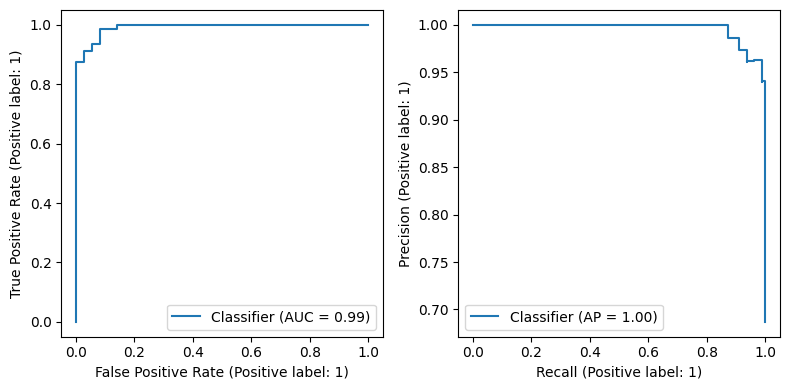

In [153]:
# Get observed data only to test predictions
any_missingflag = impres["missingflag"].any(axis=1)

# Test k-fold cross validation on ensemble model
metW, fig1, _ = KFoldEnsemble(5, ensX0, ensy0, any_missingflag,
                        RandomForestClassifier(), 
                        random_state=2023)

In [146]:
metW

{'AUROC': 0.9922644163150492,
 'Precision': 0.9625,
 'Recall': 0.9746835443037974,
 'F1': 0.9685534591194969}

In [194]:
# Test SHAP explainer
expl1, shapdf1 = CreateSHAPExplainer(ensemblerf, impres, "class_malignant")

Exact explainer: 116it [01:39,  1.04it/s]                                                    


In [195]:
shapdf1.shape

(115, 8)

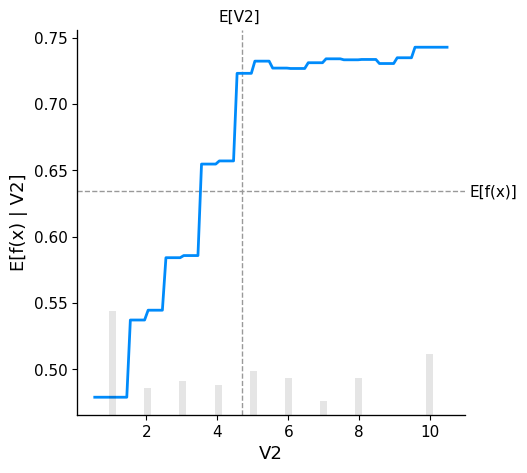

In [197]:
# Construct SHAP dependence plot
_ = GenerateDependencePlot(ensemblerf, impres, "V2", "class_malignant", shapdf1)

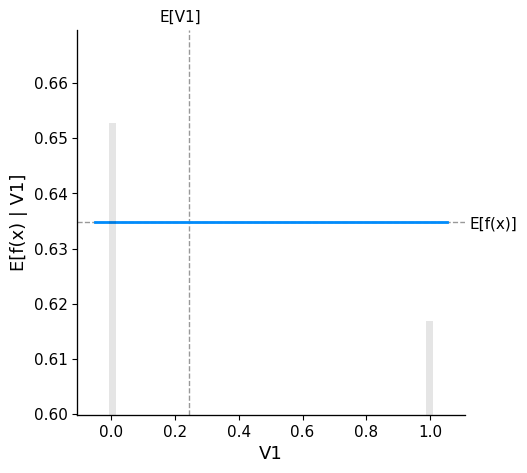

In [198]:
# Construct SHAP dependence plot
_ = GenerateDependencePlot(ensemblerf, impres, "V1", "class_malignant", shapdf1)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


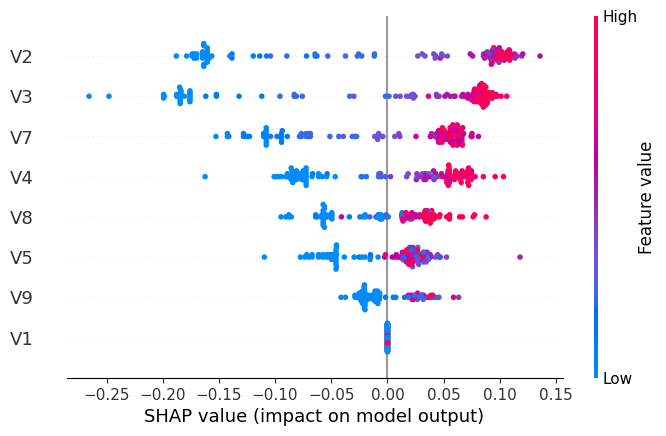

In [205]:
# Generate beeswarm plot
_ = GenerateBeeswarmPlot(ensemblerf, impres, shapdf1)
plt.savefig("../../results/figures/testbeeswarm.png")

### Method 2: Weighting method

In [124]:
# Test weighted model without cross validation
wtX, wty, w = PrepareWeightedData(impres, "class_malignant")

In [125]:
wtX.shape, wty.shape, w.shape

((1734, 8), (1734,), (1734,))

In [117]:
# Train weighted RF classifier
weightedrf = RandomForestClassifier()
weightedrf.fit(wtX, wty, sample_weight=w)

RandomForestClassifier()

In [118]:
# Get observed data only to test predictions
any_missingflag = impres["missingflag"].any(axis=1)
Xobs = impres["imp"][0].drop("class_malignant", axis=1)[any_missingflag]

# Get imputed data from the first multiply imputed data to test predictions
Ximp = impres["imp"][0].drop("class_malignant", axis=1)[~any_missingflag]

In [119]:
weightedrf.predict_proba(Xobs)

array([[0.99, 0.01],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.02, 0.98],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.02, 0.98],
       [0.  , 1.  ],
       [0.99, 0.01],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.02, 0.98],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  ,

In [121]:
weightedrf.predict_proba(Ximp)[:20, :]

array([[1.  , 0.  ],
       [0.71, 0.29],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.24, 0.76],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.12, 0.88],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.03, 0.97],
       [1.  , 0.  ],
       [0.05, 0.95],
       [0.02, 0.98]])

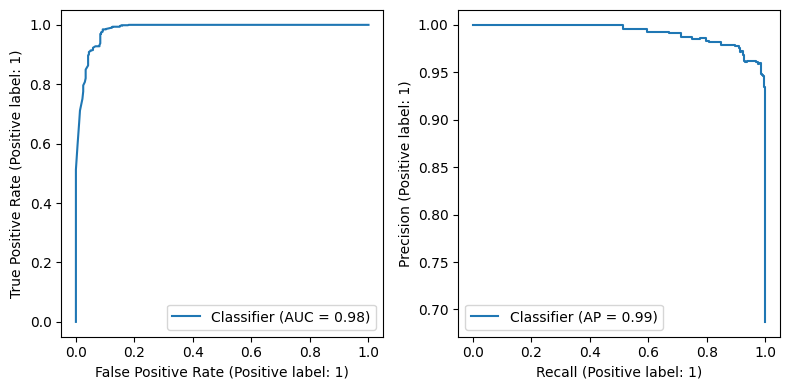

In [155]:
# Get observed data only to test predictions
any_missingflag = impres["missingflag"].any(axis=1)

# Test k-fold cross validation on weighted model
metW, fig2, _ = KFoldWeighted(5, impres, "class_malignant",
                        RandomForestClassifier(), 
                        random_state=2023)

In [180]:
# Test SHAP explainer
expl2, shapdf2 = CreateSHAPExplainer(weightedrf, impres, "class_malignant")

Exact explainer: 116it [00:10,  1.01it/s]                                                    
